<div style="position:relative; float:right"><img style="height:125px" src ="notebook_images/1200px-Star_wars2.svg.png" />
</div>
<div id="container" style="position:relative;">
<div style="float:left"><h1> Image Restoration with Deep Learning </h1></div>
<div id="container" style="position:relative;">
<div style="float:left"><h3> Episode II: Deep Learning Modeling - Basic Convolutional Autoencoder</h3></div>
<div style="float:left"><h1> </h1></div>
</div>

Author: Elaheh Shakeri
<br>
Email: elahehshakeri3@gmail.com
<br>
Date: 12th December, 2022
<br>
Notebook 2 out of 4

## Table of Contents

[Introduction](#Introduction)
<br>
[Loading and Preprocessing Data](#Loading-and-Preprocessing-Data)
<br>
[- Method 1: ImageDataGenerator and .flow_from_directory](#Method-1:-ImageDataGenerator-and-.flow_from_directory)
<br>
[- Method 2: image_dataset_from_directory](#Method-2:-image_dataset_from_directory)
<br>
[Modeling](#Modeling)
<br>
[- Convolutional Autoencoder](#Convolutional-Autoencoder)
<br>
[- Evaluation Metrics](#Evaluation-Metrics)
<br>
[Loading, Preprocessing and Modeling 2% of the Dataset](#Loading,-Preprocessing-and-Modeling-2%-of-the-Dataset)
<br>
[Loading, Preprocessing and Modeling 12% of the Dataset](#Loading,-Preprocessing-and-Modeling-12%-of-the-Dataset)
<br>
[Loading, Preprocessing and Modeling 32% of the Dataset](#Loading,-Preprocessing-and-Modeling-32%-of-the-Dataset)
<br>
[Conclusions](#Conclusions)

## Introduction

We created the train, validation and test input and output folders for our dataset in Notebook 1. In the next step, we need to load these images on to our notebook, preprocess them and then feed them into our model. We ran the next two notebooks on Google Colab Pro. Therefore, we uploaded all the image folders on to google drive and mounted the notebooks on our google drive, and unzipped the files (when necessary) with commands in this notebook.

In [1]:
# Import different packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

import os, sys
import cv2
import joblib
import glob
import math

# Importing tf tools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, ReLU, MaxPooling2D,UpSampling2D, LeakyReLU, Dropout,BatchNormalization,Activation,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras import backend as K

In [2]:
# Mounting our Colab notebook on google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Loading and Preprocessing Data

- ### Method 1: ImageDataGenerator and .flow_from_directory

We need a separate generator for each directory to load the images. The most common generator for image data is `ImageDataGenerator` that has the parameters to rescale, do validation split, horizontal_flip, vertical_flip and more. This generator is combined with `.flow_from_directory` which will accept parameters such as the directory, target image size, batch size and class mode. We did try to use this generator for our data. However, after implementing it and getting zero data back, we realized that this generator is designed for classification modeling and "only" accepts directories that have subfolders for different classes, even if you set the class_mode to None. And therfore, we did not proceed to use this method. 

In [ ]:
# changing the directory of the notebook on to our google drive
cd '/content/gdrive/My Drive/'

In [ ]:
# Defining the batch size
batch_size = 5

# Defining the image size that goes into the model
image_size = (212, 380)

In [ ]:
# Specify directories to the train and validation input and output datasets from our google drive
INPUT_TRAIN = 'mock_model_0.02/input_train_0.02'
INPUT_VAL = 'mock_model_0.02/input_val_0.02'

OUTPUT_TRAIN = 'mock_model_0.02/output_train_0.02'
OUTPUT_VAL = 'mock_model_0.02/output_val_0.02'

In [ ]:
# Defining the ImageDataGenerator for train and validation - we only normalize the data
datagen_train = ImageDataGenerator(rescale=1./255)

datagen_validation = ImageDataGenerator(rescale=1./255)

In [ ]:
# loading the train and validation data with .flow_from_directory while changing the image size and batching the data
train_generator = datagen_train.flow_from_directory(train_input,
                                                    target_size=image_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False,
                                                    )

validation_generator = datagen_validation.flow_from_directory(INPUT_VAL,
                                                    target_size=image_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


- ### Method 2: image_dataset_from_directory

As explained above this method does not work for images that do not have any corresponding labels (classes) and is best for classification models. Therefore, after much research we came across the method `tf.keras.utils.image_dataset_from_directory`. For this generator, the `labels`, `label_mode` and `class_names` could be set as None and it would be able to load the images, change their sizes, and batch them. The only aspect this method lacked was the resclaing of the images which we had to do separately. We use a map function to implement normalization on the images. To normalized the images we divide the pixel values by 255 to change the range of the pixel values from 0-255 to 0-1. Normalization is performed to make computation more efficient and faster. `image_dataset_from_directory` output is a `tf.data.Dataset`. After we perform the map function, the output changes to a `MapDataset`. We have two `MapDataset`s for our train and validation input and outputs. However, the challange is that the `.fit` function of keras will only accept separate x and y values for train and validation if they are Numpy arrays or TensorFlow tensors. As a result we will use the `tf.data.Dataset.zip` function to combine our input and outputs for train, validation and test data.

In order to visualize our images after we pass them through the generator, `.as_numpy_iterator().next()` can be used, since the data is in `tf.data.Dataset` format.

One issue that was faced while using the `tf.keras.utils.image_dataset_from_directory` generator was that at first, we only separated the datasets into train and test. We fed these datasets into our generator and relied on the generator to perform the validation split for us. We assumed that the name of the images were numerical, so the generators would pick the same images from the input and output train folders for the validation subsets. However, after visualizing the outputs of the generators, we realized that this assumption was false and we went back and created separate folders for the input and output of the train, validation and test data. We have displayed the issue for the dataset that has only been split into train and test subsets for the input and output folders.

The link to the images used to disply this issue is: https://drive.google.com/file/d/1OtUdP1SS5_AaQS5pwpfALWX_7UfEtWQj/view?usp=share_link

In [ ]:
# changing the directory of the notebook on to our google drive
cd '/content/'

/content


In [ ]:
# we unzip the folder containing the train and test input and output folders
!unzip '/content/gdrive/My Drive/capstone_images2'

Streaming output truncated to the last 5000 lines.
  inflating: input_train/0000014488.jpg  
  inflating: __MACOSX/input_train/._0000014488.jpg  
  inflating: input_train/0000004843.jpg  
  inflating: __MACOSX/input_train/._0000004843.jpg  
  inflating: input_train/0000015796.jpg  
  inflating: __MACOSX/input_train/._0000015796.jpg  
  inflating: input_train/0000012012.jpg  
  inflating: __MACOSX/input_train/._0000012012.jpg  
  inflating: input_train/0000002201.jpg  
  inflating: __MACOSX/input_train/._0000002201.jpg  
  inflating: input_train/0000014463.jpg  
  inflating: __MACOSX/input_train/._0000014463.jpg  
  inflating: input_train/0000004670.jpg  
  inflating: __MACOSX/input_train/._0000004670.jpg  
  inflating: input_train/0000010605.jpg  
  inflating: __MACOSX/input_train/._0000010605.jpg  
  inflating: input_train/0000007379.jpg  
  inflating: __MACOSX/input_train/._0000007379.jpg  
  inflating: input_train/0000000416.jpg  
  inflating: __MACOSX/input_train/._0000000416.jpg  

In [ ]:
# Defining the batch size
batch_size = 32

# Defining the image size that goes into the model
image_size = (212, 380)

In [ ]:
# Specify directories to the train and test input and output datasets from our google drive
train_input = 'input_train'
train_output = 'output_train'

test_input = 'input_test'
test_output = 'output_test'

In [ ]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
# in this version we relay on the generator to do the validation split with 0.15 fraction
input_train = tf.keras.utils.image_dataset_from_directory(
    train_input,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=27,
    validation_split=0.15,
    subset='training')

input_validation = tf.keras.utils.image_dataset_from_directory(
    train_input,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=27,
    validation_split=0.15,
    subset='validation')

Found 27007 files belonging to 1 classes.
Using 22956 files for training.
Found 27007 files belonging to 1 classes.
Using 4051 files for validation.


In [ ]:
# we have different generators for the outputs of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    train_output,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    seed=27,
    validation_split=0.15,
    subset='training')

output_validation = tf.keras.utils.image_dataset_from_directory(
    train_output,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    seed=27,
    validation_split=0.15,
    subset='validation')

Found 27007 files belonging to 1 classes.
Using 22956 files for training.
Found 27007 files belonging to 1 classes.
Using 4051 files for validation.


In [ ]:
# we use a map function to normalize the images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and output data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [ ]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.7200534 0.0


In [ ]:
# the max and min pixel value of the output train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and ouput train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


The first parameter in the shape function shown above is the batch size which is 32. The second parameter is height of the image, the third parameter is the width of the image. The forth and final parameter is the number of channels of our images. Since our images are 'rgb', the number of channels is three.

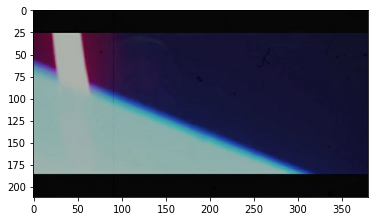

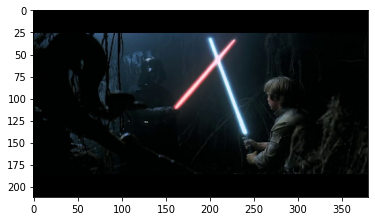

In [ ]:
# we print the paired images of the zipped train dataset for verification
plt.imshow(train.as_numpy_iterator().next()[0][31])
plt.show()
plt.imshow(train.as_numpy_iterator().next()[1][31])
plt.show()

In [ ]:
# we use a map function to normalize the validation images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and output data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.75496465 0.0


In [ ]:
# the max and min pixel value of the output validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and ouput validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


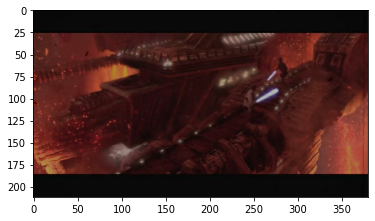

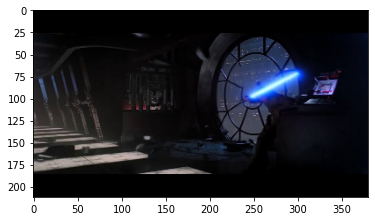

In [ ]:
# we print the paired images of the zipped validation dataset for verification
plt.imshow(validation.as_numpy_iterator().next()[0][28])
plt.show()
plt.imshow(validation.as_numpy_iterator().next()[1][28])
plt.show()

As we observe above, the input and output do not match. As a result, we created different folders for train, test and validation separately (Notebook 1) and fed them into different generators.

Now that we have presented the generator to load the images onto Python, we will proceed to explain the modeling structure we have chosen for this project. 

## Modeling

### Convolutional Autoencoder

In this project, we will use the structure of a convolutional autoencoder for our model. 

- #### Autoencoders:

Autoencoders are an unsupervised deep learning technique. They are a type of neural network with a bottleneck structure which forces the model to learn key and compressed representations of the inputs and attempts to reconstruct the input as an output with the knowledge it has learned. The key goal of autoencoders is to learn only the meaningful and significant aspects of the input data and ignore the **"noise"** and redundant information during its reconstruction. The image below is a good representation of the structure of an autoencoder and how it reconstructs an input image. 

<img src="notebook_images/keras_autoencoders_applications.png" width=500/>


- #### Convolutional Neural Networks (CNNs):

Convolutional neural networks are a deep learning algorithm similar to other neural network structures consisting of an input layer, an output layer, and one or many hidden layers. CNNs are commonly used in Computer vision for image classification, image segmentation and medical image processing. The image below shows the structure of a CNN model.

<img src="notebook_images/The-proposed-CNN-model-architecture.ppm.png" width=600/>

There are some main aspects to a CNN model. 

- Kernels: kernels are the size of the windows that are slided on the input images. We Implement convolutions on the pixels in the underlying windows. This helps to learn local features of the images. However, we do not need to implement convolutions on all the pixels on the image and we can jump a few pixels by using the hyperparameter Stride. Stride defines the number of pixels we jump each time we move the window. For example in the gif below, the kernel size is 3x3 and the stride is 1.

<img src="notebook_images/1*GcI7G-JLAQiEoCON7xFbhg.gif" width=300/>

- Pooling: Similar to convolution, pooling is accomplished by sliding a window over pixels of the image and combining all of the pixel values in that window to a new single value. Max pooling or Average pooling are two common methods. Pooling reduces the number of parameters the model needs to learn by reducing the dimensions of the image.

<img src="notebook_images/1*FHPUtGrVP6fRmVHDn3A7Rw.png" width=450/>


We will now combine the sturcture of a autoencoder and a convolutional neural networks and use a convolutional autoencoder as our model.

<img src="notebook_images/60e4224cd4055dbcc47df218_convolutional-encoder-decoder.jpg" width=450/>

The model we will use in this notebook is shown as below.
The activation function used is 'relu'. The kernel size for the convolution and convolution transpose is 3x3. The size of the max pooling window is 2x2. Since the model is pretty small, we did not drop any nodes in the model design.

In [3]:
# the input layer of the model, the image shape is (212, 380, 3)
input = layers.Input(shape=(212, 380, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input, x)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 212, 380, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 212, 380, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 190, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 190, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 106, 190, 32)     9248  

The number of trainable parameters for this model is 29,507.

### Evaluation Metrics

- #### Mean Squared Error (MSE)
The mean sqaured error between two images is the sum of the squared difference between the pixels of the two images. It is an indication of how different two images are by comparing them pixel by pixel. Since MSE comapres the two images pixel by pixel the dimensions of the two images must be the same. High MSE values mean that there a big difference between the original image and the processed (or in our case reconstructed) image. Therefore, the goal of is to minimize MSE. In our model, we have chosen MSE as our loss function. However, we still defined a function that will calculate the MSE between two images, since we would like to compare individual model outputs and ground truths.

In [4]:
def MSE(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the mean squared error between the input images
  '''
  err = np.sum((y_true.astype("float") - y_pred.astype("float")) ** 2) # sum of the squared difference between the pixels of the two images
  err /= float(y_true.shape[0] * y_true.shape[1]) # divide the error by the number pixels
  return err # returning error which is the MSE

- #### Peak Signal to Noise Ratio (PSNR)
PSNR is an approximation to human perception of reconstruction quality. It is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation. PSNR is measured in decibles. Higher PSNR means that the power of the noise is smaller which means that the reconstructed image is of higher quality. We have defined a function that calculates the PSNR of two images, and we have used it as metric in our modeling.

In [5]:
def PSNR(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the PSNR of the two images
  '''
  return tf.image.psnr(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

- #### Structural Similarity Index Measure (SSIM)
The SSIM index is used for measuring the similarity between two images. The SSIM predicts image quality based on an initial uncompressed or distortion-free image as reference. When calculating SSIM luminance, contrast and structural information between the two images are considered. SSIM of 1 translates to identical images, therefore the goal is to increase SSIM to a value close to 1.
Below is the function we defined to calculate the SSIM between two images, we used it as a metric in our model.

In [6]:
def SSIM(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the SSIM of the two images
  '''
  return tf.image.ssim(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

We will now compile the model, with the Adam algorithm as the optimizer with a learning rate of 0.0001. We set the MSE as the loss function and PSNR and SSIM as the model's evaluation metrics.

In [ ]:
autoencoder.compile(optimizer = Adam(learning_rate = 1e-4), 
               loss = 'mean_squared_error',
               metrics = [PSNR, SSIM])

## Loading, Preprocessing and Modeling 2% of the Dataset
As mentioned before, the original dataset was very large and computationaly expensive to run. Therefore, we decied to run our models on 2%, 12% and 32% of our dataset. In this section we will load and preprocess 2% of our data which is 636 paired images. We set aside 15% of this data for testing, and then split the remaining images into train and validation dataset with 85% as train and 15% as validation images.

The link to this dataset: https://drive.google.com/drive/folders/19Q6KfD1kagCj1to-_zWR_RFYoqOC-xqN?usp=sharing

In [ ]:
# Changing the directory to our google drive
cd '/content/gdrive/MyDrive/'

/content/gdrive/MyDrive


In [ ]:
# Specify directories to the train and validation input and output datasets from our google drive
INPUT_TRAIN = 'mock_model_0.02/input_train_0.02'
INPUT_VAL = 'mock_model_0.02/input_val_0.02'

OUTPUT_TRAIN = 'mock_model_0.02/output_train_0.02'
OUTPUT_VAL = 'mock_model_0.02/output_val_0.02'

In [ ]:
# Defining the batch size
batch_size = 5

# Defining the image size that goes into the model
image_size = (212, 380)

In [ ]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_VAL,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 459 files belonging to 1 classes.
Found 81 files belonging to 1 classes.


In [ ]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_VAL,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

Found 459 files belonging to 1 classes.
Found 81 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [ ]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.7364297 0.0


In [ ]:
# the max and min pixel value of the ground truth train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(5, 212, 380, 3) (5, 212, 380, 3)


MODEL TRAIN INPUT:


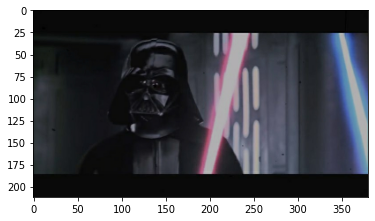

TRAIN GROUND TRUTH


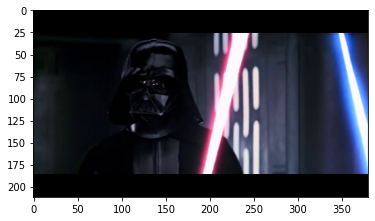

In [ ]:
# we visualize the paired images of the zipped train dataset for verification
print('MODEL TRAIN INPUT:')
plt.imshow(train.as_numpy_iterator().next()[0][4])
plt.show()
print('TRAIN GROUND TRUTH')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 21.02880859375
SSIM: 0.6402168869972229
MSE: 0.02367229383244828


In [ ]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.7440152 0.0


In [ ]:
# the max and min pixel value of the ground truth validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(5, 212, 380, 3) (5, 212, 380, 3)


MODEL VALIDATION INPUT:


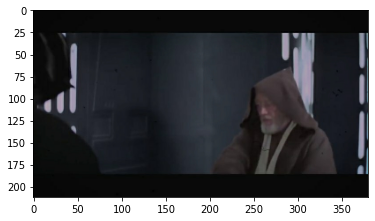

VALIDATION GROUND TRUTH:


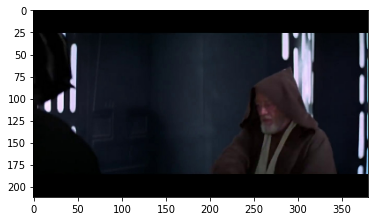

In [ ]:
# we visualize the paired images of the zipped validation dataset for verification
print('MODEL VALIDATION INPUT:')
plt.imshow(validation.as_numpy_iterator().next()[0][3])
plt.show()
print('VALIDATION GROUND TRUTH:')
plt.imshow(validation.as_numpy_iterator().next()[1][3])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for validation ground truth and model validation input:')
print(f'PCNR: {PSNR(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')
print(f'SSIM: {SSIM(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')
print(f'MSE: {MSE(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 24.117374420166016
SSIM: 0.6684763431549072
MSE: 0.011624754718392912


In [ ]:
# directories to the input and output test images
INPUT_TEST = 'mock_model_0.02/input_test_0.02'
OUTPUT_TEST = 'mock_model_0.02/output_test_0.02'

In [ ]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 96 files belonging to 1 classes.
Found 96 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

In [ ]:
# the max and min pixel value of the input test images
print(X_test.as_numpy_iterator().next().max(), X_test.as_numpy_iterator().next().min())

0.7377798 0.0


In [ ]:
# the max and min pixel value of the output test images
print(y_test.as_numpy_iterator().next().max(), y_test.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and output test images
print(X_test.as_numpy_iterator().next().shape, y_test.as_numpy_iterator().next().shape)

(5, 212, 380, 3) (5, 212, 380, 3)


MODEL TEST OUTPUT:


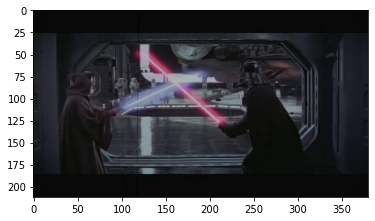

TEST GROUND TRUTH:


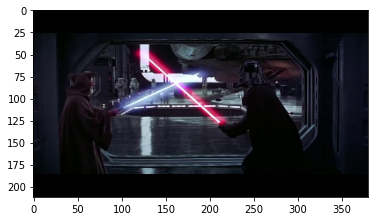

In [ ]:
# we visualize the paired images of the zipped test dataset for verification
print('MODEL TEST OUTPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][3])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()

In this step, we will fit our model with the zipped train and validation data and run the model for 100 epochs.

In [ ]:
history1 = autoencoder.fit(train,
                           epochs=100,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
92/92 [==============================] - 6s 60ms/step - loss: 0.0114 - PSNR: 21.0725 - SSIM: 0.6060 - val_loss: 0.0102 - val_PSNR: 21.0035 - val_SSIM: 0.6338
Epoch 2/100
92/92 [==============================] - 6s 67ms/step - loss: 0.0092 - PSNR: 21.8794 - SSIM: 0.6317 - val_loss: 0.0102 - val_PSNR: 20.9805 - val_SSIM: 0.6360
Epoch 3/100
92/92 [==============================] - 7s 76ms/step - loss: 0.0087 - PSNR: 22.0955 - SSIM: 0.6373 - val_loss: 0.0099 - val_PSNR: 21.0912 - val_SSIM: 0.6359
Epoch 4/100
92/92 [==============================] - 6s 69ms/step - loss: 0.0082 - PSNR: 22.3322 - SSIM: 0.6414 - val_loss: 0.0093 - val_PSNR: 21.3391 - val_SSIM: 0.6300
Epoch 5/100
92/92 [==============================] - 5s 58ms/step - loss: 0.0074 - PSNR: 22.6643 - SSIM: 0.6428 - val_loss: 0.0083 - val_PSNR: 21.8028 - val_SSIM: 0.6359
Epoch 6/100
92/92 [==============================] - 6s 64ms/step - loss: 0.0064 - PSNR: 23.2140 - SSIM: 0.6497 - val_loss: 0.0071 - val_PSNR: 22.4365

We will visualize the loss function (MSE) and the evaluation metrics PSNR and SSIM for the train and validation data after running the model for 100 epochs.

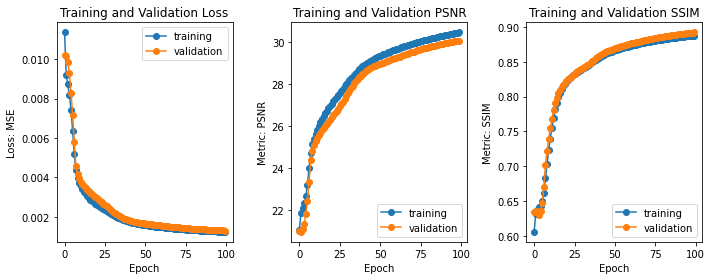

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history1.history['loss'], marker='o', label='training')
plt.plot(history1.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history1.history['PSNR'], marker='o', label='training')
plt.plot(history1.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history1.history['SSIM'], marker='o', label='training')
plt.plot(history1.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

We observe that the MSE decreases while PSNR and SSIM increase as the model goes through the epochs. There is no sign of over fitting in the graphs, since we dont see a divergence between the train and validation data.

To visualize how to the model is performing on the training images, we visualize the output of the model for a training image and compare it to the ground truth.

In [ ]:
# get the model predictions for the input training data
train_predictions = autoencoder.predict(X_train)

92/92 [==============================] - 2s 21ms/step


In [ ]:
# max and min value for the reconstructed images
print(train_predictions.max(), train_predictions.min())

1.4059926 0.0


While the maximum and minimum for the pixel values should be between 0 and 1, the max is higher due to the use of the relu function, however when we used the sigmoid function to ensure that the pixel values remain between 0 and 1 the model did not perform well at all. The matplotlib function, imshow, will clip the pixel values to between 0 and 1. So the output images can be displayed.

We display the ground truth and model output, so visualize how the model reconstructed the train images. 

TRAIN GROUND TRUTH:


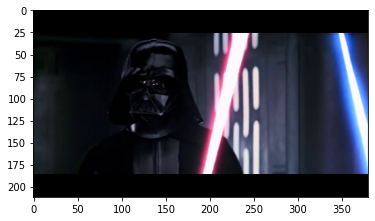

MODEL TRAIN OUTPUT:


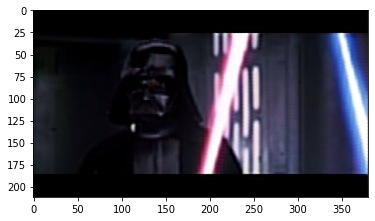

In [ ]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[4])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 30.487590789794922
SSIM: 0.9255592226982117
MSE: 0.0026814017640950103


After observing the performance of the model on the training data, we will pass the test data through our model to see how the model performs with the data it has not seen before.

In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

20/20 [==============================] - 1s 42ms/step - loss: 0.0013 - PSNR: 30.0583 - SSIM: 0.8834


[0.0012843679869547486, 30.058279037475586, 0.8834454417228699]

The summary for this trained model is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |   0.0012    |   30.44    |  0.8877          |
|Validation   |  0.0013    |   30.06    |  0.8922           |
|Test  |   0.0013    |    30.06     |  0.8834         |


We will now pass the input test images into our model to see how the model reconstructs the test images. We will visualize and evaluate individual images for our reference.

In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

20/20 [==============================] - 0s 23ms/step


In [ ]:
# get the shape of the reconstructed test data
test_predictions.shape

(96, 212, 380, 3)

As mentioned before the first value is the batchsize, the second and third values are the dimensions of the images and the final value is the number of channels for the images and since are images are rgb this value is 3.

In [ ]:
# min and max pixel values for model test outputs
print(test_predictions.max(), test_predictions.min())

1.329366 0.0


TEST GROUND TRUTH:


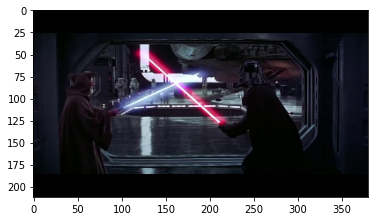

MODEL TEST OUTPUT:


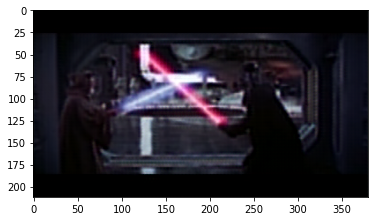

In [ ]:
# visualize the test ground truth and the model test output
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[3])
plt.show()

We use the evaluation metrics on an indivudual test ground truth and model test output.

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 26.932140350341797
SSIM: 0.8430553078651428
MSE: 0.006080048807555147


We observe that the model has reconstructed the image pretty well, even though the structure of the convolutional autoencoder is very basic and the number of images passed through the model is low. As we saw in the plots for the model performance, no signs of overfitting was observed so we will train our model with the same dataset again but this time for another 200 epochs to see how much the performance of the model can be improved.

In [ ]:
history1_2 = autoencoder.fit(train,
                           epochs=200,
                           validation_data= validation,
                           verbose=1)

Epoch 1/200
92/92 [==============================] - 6s 61ms/step - loss: 0.0012 - PSNR: 30.4710 - SSIM: 0.8882 - val_loss: 0.0013 - val_PSNR: 30.0585 - val_SSIM: 0.8906
Epoch 2/200
92/92 [==============================] - 6s 59ms/step - loss: 0.0013 - PSNR: 30.3887 - SSIM: 0.8870 - val_loss: 0.0013 - val_PSNR: 30.0653 - val_SSIM: 0.8921
Epoch 3/200
92/92 [==============================] - 5s 56ms/step - loss: 0.0012 - PSNR: 30.4962 - SSIM: 0.8884 - val_loss: 0.0013 - val_PSNR: 30.1076 - val_SSIM: 0.8925
Epoch 4/200
92/92 [==============================] - 5s 56ms/step - loss: 0.0012 - PSNR: 30.5180 - SSIM: 0.8888 - val_loss: 0.0013 - val_PSNR: 30.1235 - val_SSIM: 0.8928
Epoch 5/200
92/92 [==============================] - 6s 61ms/step - loss: 0.0012 - PSNR: 30.5343 - SSIM: 0.8891 - val_loss: 0.0013 - val_PSNR: 30.1372 - val_SSIM: 0.8931
Epoch 6/200
92/92 [==============================] - 7s 71ms/step - loss: 0.0012 - PSNR: 30.5484 - SSIM: 0.8893 - val_loss: 0.0013 - val_PSNR: 30.1499

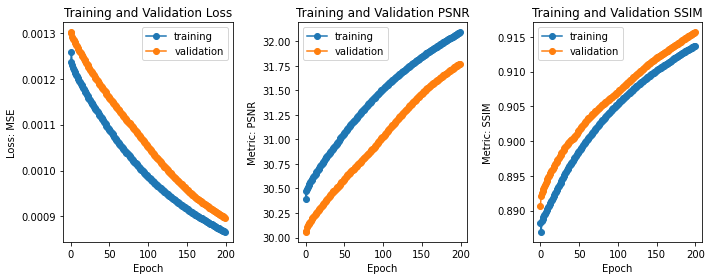

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history1_2.history['loss'], marker='o', label='training')
plt.plot(history1_2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history1_2.history['PSNR'], marker='o', label='training')
plt.plot(history1_2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history1_2.history['SSIM'], marker='o', label='training')
plt.plot(history1_2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

We see that with furthur training, the loss decreases while the SSIM and PSNR increase as the model goes through the epochs. 

For the 2% sample dataset, after training the model for 100 and 300 epochs the model evaluation metrics for the training and validation images are as below:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |  0.0012    |   30.44    |  0.8877          |
|Model trained for 300 epochs   |   0.00087    |    32.09     |  0.9137          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |  0.0013    |   30.06    |  0.8922          |
|Model trained for 300 epochs   |   0.0009    |    31.77     |  0.9156          |

We see an improvement after training the model for an additional 200 epochs which was predictable. 

We will now visualize individual outputs of the model for the train data:


In [ ]:
# we will get the predictions of the test input 
train_predictions = autoencoder.predict(X_train)

92/92 [==============================] - 2s 21ms/step


TRAIN GROUND TRUTH:


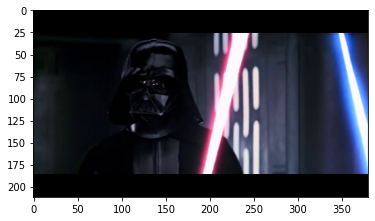

MODEL TRAIN OUTPUT:


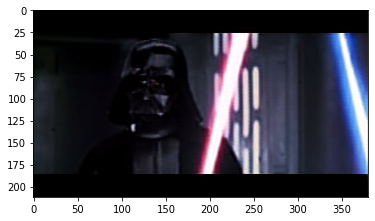

In [ ]:
# visualize the groud truth and model output for a train image
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[4])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 32.681236267089844
SSIM: 0.9423055052757263
MSE: 0.001618070861912988


After observing the performance of the model on the training data, we will pass the test data through our model to see how the model performs with the data it has not seen before.

In [ ]:
autoencoder.evaluate(test, verbose=1)

20/20 [==============================] - 1s 41ms/step - loss: 9.1043e-04 - PSNR: 31.6794 - SSIM: 0.9076


[0.0009104313794523478, 31.679410934448242, 0.9075755476951599]

The summary of the model performance after running for 300 epochs is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |    0.00087    |    32.09     |  0.9137             |
|Validation   |   0.0009    |    31.77     |  0.9156          |
|Test  |  0.0009    |    31.68     |  0.9075       |


<br>
We will now compare the evaluation metrics for the test images after training the model for 100 and 300 epochs.



**Test images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |  0.0013    |   30.06   |  0.8834          |
|Model trained for 300 epochs   |   0.0009    |    31.68     |  0.9075          |

Similar to the trend for train and validation data, the models performance improves after training another 200 epochs. 

We will now visualize the ground truth and the model output for an individual test image, and compare them using the evaluation metrics.

In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

20/20 [==============================] - 0s 21ms/step


In [ ]:
# get the shape of the reconstructed test data
test_predictions.shape

(96, 212, 380, 3)

TEST GROUND TRUTH:


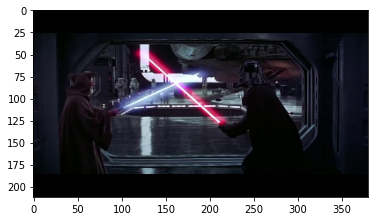

MODEL TEST OUTPUT:


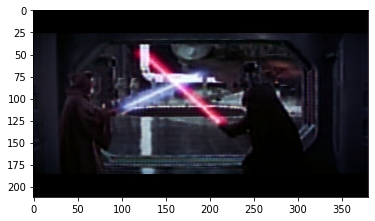

In [ ]:
# visualize the test ground truth and the model test output
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[3])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 28.283676147460938
SSIM: 0.8814525008201599
MSE: 0.004454034466421892


We observe that the evalution metrics are acceptable, however the image itself can be considered blurry which is the result of our small structure. With a bigger structure, the model is able to learn more information from the images by gradually reducing the size of the image during its convolution and pooling layers. However, we can see that that the model has learned to improve the liveliness of the images by making the colors more vivid. 


We will now evaluate the performance of the model trained with 2% of the dataset for 300 epochs with a dataset of low resolution old images to see how the model will reconstruct these images.

In [ ]:
# directory to the old image test dataset
TEST_IMAGE_DATA = '/content/gdrive/MyDrive/test_old_images'

In [ ]:
# defining the batch and image size
image_size = (212, 380)
batch_size = 32

In [ ]:
# loading the test data with .image_dataset_from_directory while changing the image size and batching the data
test_image_data = tf.keras.utils.image_dataset_from_directory(
    TEST_IMAGE_DATA,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 188 files belonging to 1 classes.


In [ ]:
# normalizing the images using map function
test_image = test_image_data.map(lambda test: test/255.0)

TEST INPUT 1:


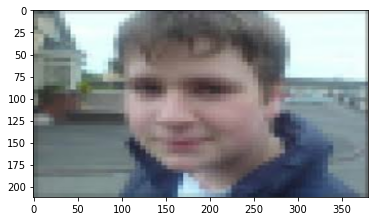

TEST INPUT 2:


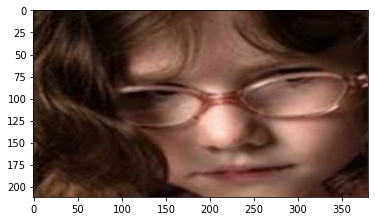

In [ ]:
# visualizing 2 random pictures from the dataset
print('TEST INPUT 1:')
plt.imshow(test_image.as_numpy_iterator().next()[17])
plt.show()
print('TEST INPUT 2:')
plt.imshow(test_image.as_numpy_iterator().next()[29])
plt.show()

In [ ]:
# passing the images through our data to get the model prediction
test_image_predictions = autoencoder.predict(test_image)

6/6 [==============================] - 2s 237ms/step


MODEL TEST OUTPUT 1:


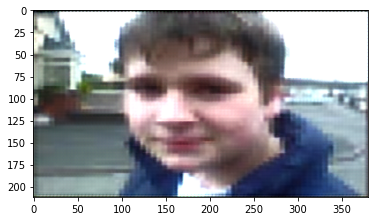

MODEL TEST OUTPUT 2:


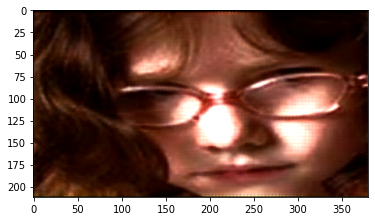

In [ ]:
# Visualizing the same two pictures after the model reconstruction
print('MODEL TEST OUTPUT 1:')
plt.imshow(test_image_predictions[17])
plt.show()
print('MODEL TEST OUTPUT 2:')
plt.imshow(test_image_predictions[29])
plt.show()

While not being able to improve the quality of the images, which is a result of the small structure of the model, the colors are more vivid in after they are passed through the model.

## Loading, Preprocessing and Modeling 12% of the Dataset

In this section we will train the same model as before, but on 12% of the data which amounts to 3816 paired images. Similar to before, we will set aside 15% of the data points for testing, and divide the remaining data points between validation and train images, with 85% as train and 15% as validation data points.

The link to this dataset: https://drive.google.com/file/d/1GvIiE7RYqHZFKYonVhSNAgZoztjcotFG/view?usp=sharing

In [ ]:
# we unzip the file containing the 12% dataset
!unzip '/content/gdrive/My Drive/mock_model_0.12'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/output_train_0.12/._0000003168.jpg  
  inflating: output_train_0.12/0000019130.jpg  
  inflating: __MACOSX/output_train_0.12/._0000019130.jpg  
  inflating: output_train_0.12/0000006776.jpg  
  inflating: __MACOSX/output_train_0.12/._0000006776.jpg  
  inflating: output_train_0.12/0000014372.jpg  
  inflating: __MACOSX/output_train_0.12/._0000014372.jpg  
  inflating: output_train_0.12/0000008773.jpg  
  inflating: __MACOSX/output_train_0.12/._0000008773.jpg  
  inflating: output_train_0.12/0000027790.jpg  
  inflating: __MACOSX/output_train_0.12/._0000027790.jpg  
  inflating: output_train_0.12/0000001743.jpg  
  inflating: __MACOSX/output_train_0.12/._0000001743.jpg  
  inflating: output_train_0.12/0000013421.jpg  
  inflating: __MACOSX/output_train_0.12/._0000013421.jpg  
  inflating: output_train_0.12/0000014819.jpg  
  inflating: __MACOSX/output_train_0.12/._0000014819.jpg  
  inflating: output_train_0.12/000

In [ ]:
cd '/content/'

/content


In [ ]:
# directories to the train and validation input and output datasets
INPUT_TRAIN = 'input_train_0.12'
INPUT_VAL = 'input_val_0.12'

OUTPUT_TRAIN = 'output_train_0.12'
OUTPUT_VAL = 'output_val_0.12'

In [ ]:
# we specify the batch size and traget image size
batch_size = 32
image_size = (212, 380)

In [ ]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_VAL,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 2755 files belonging to 1 classes.
Found 486 files belonging to 1 classes.


In [ ]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_VAL,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

Found 2755 files belonging to 1 classes.
Found 486 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [ ]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.7541982 0.0


In [ ]:
# the max and min pixel value of the ground truth train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


MODEL TRAIN INPUT:


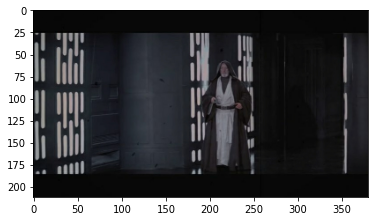

TRAIN GROUND TRUTH:


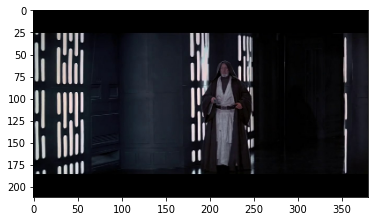

In [ ]:
# we visualize the paired images of the zipped train dataset for verification
print('MODEL TRAIN INPUT:')
plt.imshow(train.as_numpy_iterator().next()[0][20])
plt.show()
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][20])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][20], train.as_numpy_iterator().next()[1][20])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][20], train.as_numpy_iterator().next()[1][20])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][20], train.as_numpy_iterator().next()[1][20])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.66360092163086
SSIM: 0.6587014198303223
MSE: 0.012905088907554596


In [ ]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.75134116 0.0


In [ ]:
# the max and min pixel value of the ground truth validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


MODEL VALIDATION INPUT:


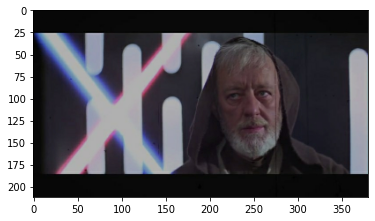

VALIDATION GROUND TRUTH:


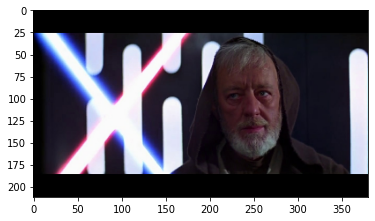

In [ ]:
# we visualize the paired images of the zipped validation dataset for verification
print('MODEL VALIDATION INPUT:')
plt.imshow(validation.as_numpy_iterator().next()[0][28])
plt.show()
print('VALIDATION GROUND TRUTH:')
plt.imshow(validation.as_numpy_iterator().next()[1][28])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for validation ground truth and model validation input:')
print(f'PCNR: {PSNR(validation.as_numpy_iterator().next()[0][28], validation.as_numpy_iterator().next()[1][28])}')
print(f'SSIM: {SSIM(validation.as_numpy_iterator().next()[0][28], validation.as_numpy_iterator().next()[1][28])}')
print(f'MSE: {MSE(validation.as_numpy_iterator().next()[0][28], validation.as_numpy_iterator().next()[1][28])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 17.850522994995117
SSIM: 0.7128490805625916
MSE: 0.049211747585248475


In [ ]:
# directories to the input and output test images
INPUT_TEST = 'input_test_0.12'
OUTPUT_TEST = 'output_test_0.12'

In [ ]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 573 files belonging to 1 classes.
Found 573 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

MODEL TEST INPUT:


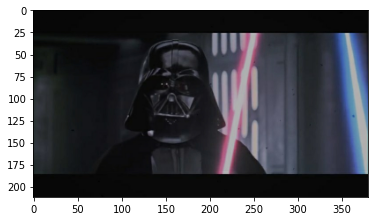

TEST GROUND TRUTH:


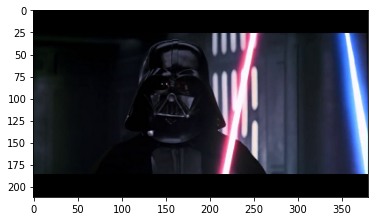

In [ ]:
print('MODEL TEST INPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][5])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')

Evaluation metrics for test ground truth and model test input:
PCNR: 22.011796951293945
SSIM: 0.6588255167007446
MSE: 0.018877370948266425


In [ ]:
# the input layer of the model, the image shape is (212, 380, 3)
input = layers.Input(shape=(212, 380, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input, x)

In [ ]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 212, 380, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 212, 380, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 106, 190, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 190, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 106, 190, 32)     9248

In [ ]:
autoencoder.compile(optimizer = Adam(learning_rate = 1e-4), 
               loss = 'mean_squared_error',
               metrics = [PSNR, SSIM])

In [ ]:
history2 = autoencoder.fit(train,
                           epochs=100,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
87/87 [==============================] - 35s 292ms/step - loss: 0.0534 - PSNR: 14.8564 - SSIM: 0.2710 - val_loss: 0.0253 - val_PSNR: 17.1219 - val_SSIM: 0.1849
Epoch 2/100
87/87 [==============================] - 23s 262ms/step - loss: 0.0176 - PSNR: 18.6636 - SSIM: 0.3191 - val_loss: 0.0137 - val_PSNR: 19.7663 - val_SSIM: 0.4612
Epoch 3/100
87/87 [==============================] - 23s 267ms/step - loss: 0.0113 - PSNR: 20.8909 - SSIM: 0.5769 - val_loss: 0.0108 - val_PSNR: 20.9557 - val_SSIM: 0.6082
Epoch 4/100
87/87 [==============================] - 25s 280ms/step - loss: 0.0090 - PSNR: 21.7692 - SSIM: 0.6178 - val_loss: 0.0099 - val_PSNR: 21.2293 - val_SSIM: 0.6010
Epoch 5/100
87/87 [==============================] - 23s 262ms/step - loss: 0.0079 - PSNR: 22.2394 - SSIM: 0.6099 - val_loss: 0.0088 - val_PSNR: 21.6631 - val_SSIM: 0.6022
Epoch 6/100
87/87 [==============================] - 23s 267ms/step - loss: 0.0068 - PSNR: 22.7951 - SSIM: 0.6117 - val_loss: 0.0074 - val_P

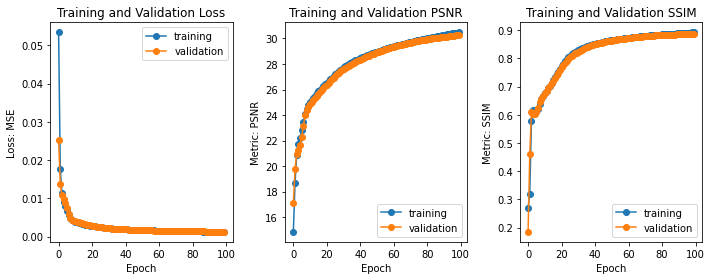

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history2.history['loss'], marker='o', label='training')
plt.plot(history2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history2.history['PSNR'], marker='o', label='training')
plt.plot(history2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history2.history['SSIM'], marker='o', label='training')
plt.plot(history2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

Similar to what we saw for the 2% sample data set, after trainig the model for 100 epochs we observe that the MSE decreases while PSNR and SSIM increase as the model goes through the epochs. There is no sign of over fitting in the graphs, since we dont see a divergence between the train and validation data.

We can compare the performance of the models on the train and validation images after training for 100 epochs for the 2% and 12% sample datasets:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0012    |   30.44    |  0.8877          |
|12% Sample dataset  |   0.0012    |    30.48     |  0.8922          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0013    |   30.06    |  0.8922          |
|12% Sample dataset   |   0.0013    |    30.29     |  0.8877         |


**We see that there is very little difference between the models trained with ~690 images and ~3800 images. Which is an interesting observation.**

To visualize how to the model is performing on the training images, we visualize the output of the model for a training image and compare it to the ground truth.

In [ ]:
# get the model predictions for the input training data
train_predictions = autoencoder.predict(X_train)

87/87 [==============================] - 9s 101ms/step


In [ ]:
# max and min value for the reconstructed images
print(train_predictions.max(), train_predictions.min())

1.3399414 0.0


TRAIN GROUND TRUTH:


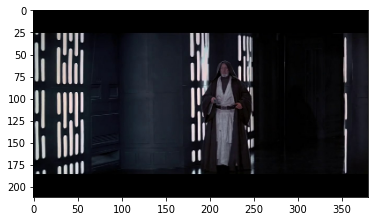

MODEL TRAIN OUTPUT:


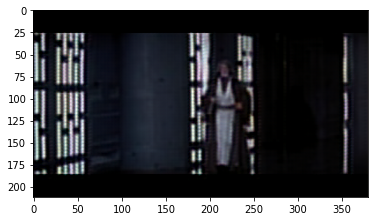

In [ ]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][20])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[20])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.76610565185547
SSIM: 0.573275625705719
MSE: 0.012604064581849523


In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

18/18 [==============================] - 5s 267ms/step - loss: 0.0013 - PSNR: 30.3122 - SSIM: 0.8876


[0.0012719538062810898, 30.312231063842773, 0.8875740170478821]

The summary of the model performance after running for 100 epochs is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |   0.0012    |    30.48     |  0.8922             |
|Validation   |  0.0013    |    30.29     |  0.8877          |
|Test  |  0.0013    |    30.31     |  0.8876      |

<br>

We can now compare the performance of the model on the test images after training for 100 epochs for the 2% and 12% sample datasets:


| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0013    |   30.06   |  0.8834       |
|12% Sample dataset   |   0.0013    |    30.31     |  0.8876         |

Similar to what we saw for the train and validation images, the difference in the metrics for the testing data when the model is trained with ~690 images and ~3800 images are **not noticable**.

In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

18/18 [==============================] - 2s 106ms/step


In [ ]:
# get the shape of the reconstructed test data
test_predictions.shape

(573, 212, 380, 3)

In [ ]:
# min and max pixel values for model test outputs
print(test_predictions.max(), test_predictions.min())

1.2935166 0.0


TEST GROUND TRUTH:


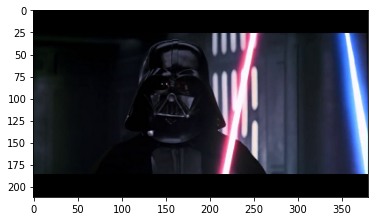

MODEL TEST OUTPUT:


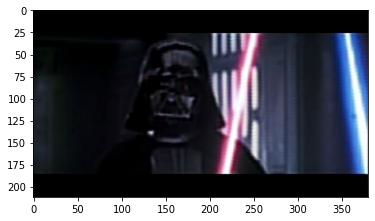

In [ ]:
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[5])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 30.358985900878906
SSIM: 0.924115002155304
MSE: 0.0027619925019283357


Since we saw no divergence in the MSE loss plot for the training and validation data, we will train the model for an additional 200 epochs to see if we can improve the performance of the model.

In [ ]:
history2_2 = autoencoder.fit(train,
                           epochs=200,
                           validation_data= validation,
                           verbose=1)

Epoch 1/200
87/87 [==============================] - 24s 268ms/step - loss: 0.0012 - PSNR: 30.4969 - SSIM: 0.8925 - val_loss: 0.0013 - val_PSNR: 30.3084 - val_SSIM: 0.8881
Epoch 2/200
87/87 [==============================] - 23s 263ms/step - loss: 0.0012 - PSNR: 30.5159 - SSIM: 0.8929 - val_loss: 0.0013 - val_PSNR: 30.3281 - val_SSIM: 0.8884
Epoch 3/200
87/87 [==============================] - 23s 257ms/step - loss: 0.0012 - PSNR: 30.5344 - SSIM: 0.8932 - val_loss: 0.0013 - val_PSNR: 30.3472 - val_SSIM: 0.8888
Epoch 4/200
87/87 [==============================] - 23s 263ms/step - loss: 0.0012 - PSNR: 30.5527 - SSIM: 0.8935 - val_loss: 0.0012 - val_PSNR: 30.3665 - val_SSIM: 0.8891
Epoch 5/200
87/87 [==============================] - 23s 260ms/step - loss: 0.0012 - PSNR: 30.5708 - SSIM: 0.8938 - val_loss: 0.0012 - val_PSNR: 30.3851 - val_SSIM: 0.8895
Epoch 6/200
87/87 [==============================] - 23s 257ms/step - loss: 0.0012 - PSNR: 30.5887 - SSIM: 0.8942 - val_loss: 0.0012 - val_P

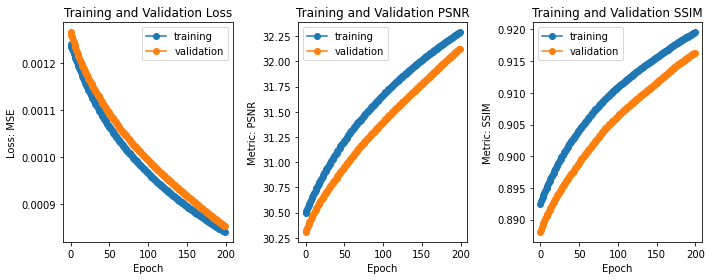

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history2_2.history['loss'], marker='o', label='training')
plt.plot(history2_2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history2_2.history['PSNR'], marker='o', label='training')
plt.plot(history2_2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history2_2.history['SSIM'], marker='o', label='training')
plt.plot(history2_2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

After trainig the model for an additional 200 epochs (300 in total) we observe that the MSE still decreases while PSNR and SSIM increase as the model goes through the epochs. There is still no sign of over fitting in the graphs, since we dont see a divergence between the train and validation data plots.

For the 12% sample dataset, after training the model for 100 and 300 epochs the model evaluation metrics for the training and validation images are as below:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |  0.0012    |    30.48     |  0.8922         |
|Model trained for 300 epochs   |   0.00084    |    32.29    |  0.9195          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |  0.0013    |    30.29     |  0.8877         |
|Model trained for 300 epochs   |   0.00085    |    32.16     |  0.9163          |


The model performance increases after we train it for an additional 200 epochs. However, it would be inetersting to compare these results with the 2% sample dataset metrics.


We can compare the performance of the models after training for 300 epochs for the 2% and 12% sample datasets:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |   0.00087    |    32.09     |  0.9137        |
|12% Sample dataset  |  0.00084    |    32.29    |  0.9195         |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |   0.0009    |    31.77     |  0.9156           |
|12% Sample dataset   |   0.00085    |    32.16     |  0.9163            |

We can see very small improvements for the 12% sample dataset as the number of epochs increases.


In [ ]:
train_predictions = autoencoder.predict(X_train)

87/87 [==============================] - 9s 102ms/step


TRAIN GROUND TRUTH:


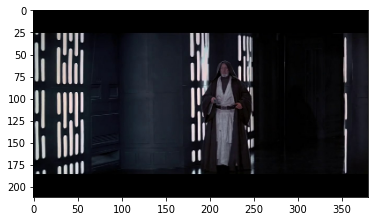

MODEL TRAIN OUTPUT:


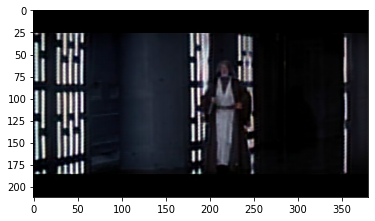

In [ ]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][20])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[20])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][20], train_predictions[20])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.057849884033203
SSIM: 0.5986228585243225
MSE: 0.014836658812976402


In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

18/18 [==============================] - 5s 245ms/step - loss: 8.4318e-04 - PSNR: 32.1642 - SSIM: 0.9173


[0.000843180576339364, 32.16424560546875, 0.9173267483711243]

The summary of the model performance after running for 300 epochs is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |   0.00084    |    32.29    |  0.9195          |
|Validation   |  0.00085    |    32.16     |  0.9163                |
|Test  | 0.00084    |    32.16     |  0.9173      |


<br>

We can compare the performance of the model on the test images after training the model for an additional 200 epochs:


**Test images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |   0.0013    |    30.31     |  0.8876    |
|Model trained for 300 epochs   |   0.0008    |    32.16     |  0.9173         |

The model performance is improved for the testing data after it is trained for an additional 200 epochs.

In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

18/18 [==============================] - 2s 107ms/step


In [ ]:
# get the shape of the reconstructed test data
test_predictions.shape

(573, 212, 380, 3)

In [ ]:
# min and max pixel values for model test outputs
print(test_predictions.max(), test_predictions.min())

1.4786534 0.0


TEST GROUND TRUTH:


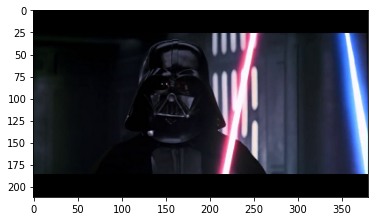

MODEL TEST OUTPUT:


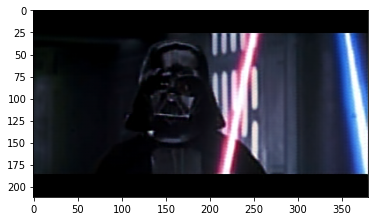

In [ ]:
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[5])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 32.82343292236328
SSIM: 0.9471156001091003
MSE: 0.0015659493865302447


We will now evaluate the performance of the our model which has been trained on 12% of our dataset for 300 epochs. In order to so, we use a dataset containing low resolution old images, and test our model with these images. 

TEST INPUT 1:


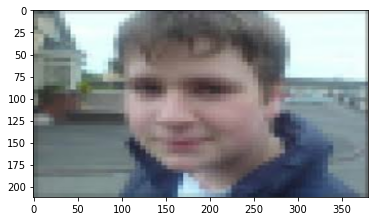

TEST INPUT 2:


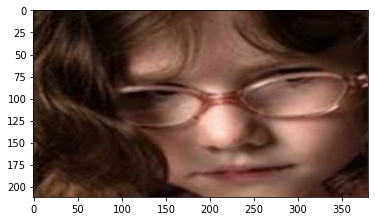

In [ ]:
# Visualizing two random pictures from the old image test dataset
print('TEST INPUT 1:')
plt.imshow(test_image.as_numpy_iterator().next()[17])
plt.show()
print('TEST INPUT 2:')
plt.imshow(test_image.as_numpy_iterator().next()[29])
plt.show()

In [ ]:
# passing the images through the trained model
test_image_predictions = autoencoder.predict(test_image)

6/6 [==============================] - 2s 423ms/step


MODEL TEST OUTPUT 1:


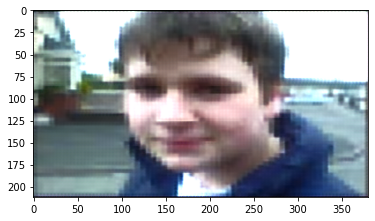

MODEL TEST OUTPUT 2:


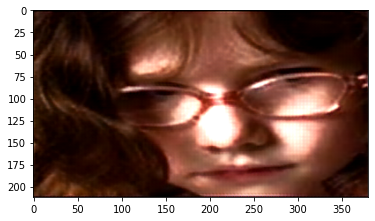

In [ ]:
# visualizing the reconstruced images by the model
print('MODEL TEST OUTPUT 1:')
plt.imshow(test_image_predictions[17])
plt.show()
print('MODEL TEST OUTPUT 2:')
plt.imshow(test_image_predictions[29])
plt.show()

While not being able to improve the quality of the images, which is a result of the small structure of the model, the colors are more vivid after they are passed through the model. 

## Loading, Preprocessing and Modeling 32% of the Dataset

Finally, in this section we will train the same model as before, but on 32% of the data which amounts to 10,176 paired images . Similar to before, we will set aside 15% of the data points for testing, and divide the remaining data points between validation and train images, with 85% as train and 15% as validation data points.

The link to this dataset: https://drive.google.com/file/d/1l1UriuQwoY0hl1b-Y8MGT2oCseDIf3Vm/view?usp=sharing

In [7]:
!unzip '/content/gdrive/My Drive/mock_model_0.32'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/input_val_0.32/._0000009766.jpg  
  inflating: input_val_0.32/0000013716.jpg  
  inflating: __MACOSX/input_val_0.32/._0000013716.jpg  
  inflating: input_val_0.32/0000026961.jpg  
  inflating: __MACOSX/input_val_0.32/._0000026961.jpg  
  inflating: input_val_0.32/0000004097.jpg  
  inflating: __MACOSX/input_val_0.32/._0000004097.jpg  
  inflating: input_val_0.32/0000017955.jpg  
  inflating: __MACOSX/input_val_0.32/._0000017955.jpg  
  inflating: input_val_0.32/0000013299.jpg  
  inflating: __MACOSX/input_val_0.32/._0000013299.jpg  
  inflating: input_val_0.32/0000027114.jpg  
  inflating: __MACOSX/input_val_0.32/._0000027114.jpg  
  inflating: input_val_0.32/0000019788.jpg  
  inflating: __MACOSX/input_val_0.32/._0000019788.jpg  
  inflating: input_val_0.32/0000014521.jpg  
  inflating: __MACOSX/input_val_0.32/._0000014521.jpg  
  inflating: input_val_0.32/0000013528.jpg  
  inflating: __MACOSX/input_val_0.32/._0

In [10]:
# changing the directory of the notebook on to our google colab (we unzipped the file onto our google colab)
cd '/content/'

/content


In [11]:
# Specify directories to the train and validation input and output datasets
INPUT_TRAIN = 'input_train_0.32'
INPUT_VAL = 'input_val_0.32'

OUTPUT_TRAIN = 'output_train_0.32'
OUTPUT_VAL = 'output_val_0.32'

In [12]:
# Defining the batch size and image target size
batch_size = 32
image_size = (212, 380)

In [13]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_VAL,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 7346 files belonging to 1 classes.
Found 1298 files belonging to 1 classes.


In [14]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_VAL,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

Found 7346 files belonging to 1 classes.
Found 1298 files belonging to 1 classes.


In [15]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [16]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.7374428 0.0


In [17]:
# the max and min pixel value of the ground truth train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [18]:
# shape of the input and groundtruth train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


MODEL TRAIN INPUT:


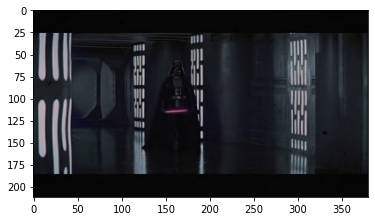

TRAIN GROUND TRUTH:


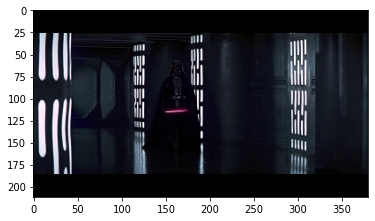

In [52]:
# we visualize the paired images of the zipped train dataset for verification
print('MODEL TRAIN INPUT:')
plt.imshow(train.as_numpy_iterator().next()[0][29])
plt.show()
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][29])
plt.show()

In [53]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][29], train.as_numpy_iterator().next()[1][29])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][29], train.as_numpy_iterator().next()[1][29])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][29], train.as_numpy_iterator().next()[1][29])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.21019744873047
SSIM: 0.7294859886169434
MSE: 0.014325224829040743


In [29]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [30]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.76542866 0.0


In [31]:
# the max and min pixel value of the ground truth validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [32]:
# shape of the input and groundtruth validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(32, 212, 380, 3) (32, 212, 380, 3)


MODEL VALIDATION INPUT:


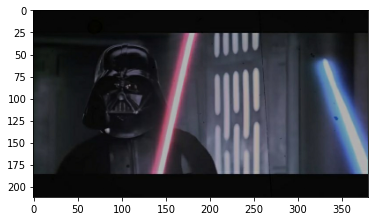

VALIDATION GROUND TRUTH:


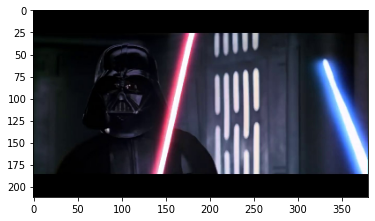

In [33]:
# we visualize the paired images of the zipped validation dataset for verification
print('MODEL VALIDATION INPUT:')
plt.imshow(validation.as_numpy_iterator().next()[0][13])
plt.show()
print('VALIDATION GROUND TRUTH:')
plt.imshow(validation.as_numpy_iterator().next()[1][13])
plt.show()

In [34]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for validation ground truth and model validation input:')
print(f'PCNR: {PSNR(validation.as_numpy_iterator().next()[0][13], validation.as_numpy_iterator().next()[1][13])}')
print(f'SSIM: {SSIM(validation.as_numpy_iterator().next()[0][13], validation.as_numpy_iterator().next()[1][13])}')
print(f'MSE: {MSE(validation.as_numpy_iterator().next()[0][13], validation.as_numpy_iterator().next()[1][13])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 21.699277877807617
SSIM: 0.6857379078865051
MSE: 0.020285859042252958


In [36]:
# directories to the input and output test images
INPUT_TEST = 'input_test_0.32'
OUTPUT_TEST = 'output_test_0.32'

In [37]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 1525 files belonging to 1 classes.
Found 1525 files belonging to 1 classes.


In [38]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

MODEL TEST INPUT:


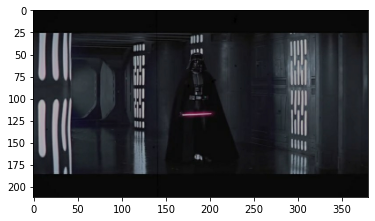

TEST GROUND TRUTH:


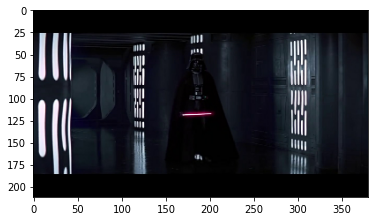

In [56]:
# we visualize the paired images of the zipped test dataset for verification
print('MODEL TEST INPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][7])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][7])
plt.show()

In [57]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for test ground truth and model validation input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][7],test.as_numpy_iterator().next()[1][7])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][7], test.as_numpy_iterator().next()[1][7])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][7], test.as_numpy_iterator().next()[1][7])}')

Evaluation metrics for test ground truth and model validation input:
PCNR: 22.593021392822266
SSIM: 0.6498207449913025
MSE: 0.016512732501275947


In [45]:
# the input layer of the model, the image shape is (212, 380, 3)
input = layers.Input(shape=(212, 380, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input, x)

In [46]:
autoencoder.compile(optimizer = Adam(learning_rate = 1e-4), 
               loss = 'mean_squared_error',
               metrics = [PSNR, SSIM])

In [47]:
history3 = autoencoder.fit(train,
                           epochs=100,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
230/230 [==============================] - 90s 349ms/step - loss: 0.0304 - PSNR: 17.2451 - SSIM: 0.3108 - val_loss: 0.0186 - val_PSNR: 18.4436 - val_SSIM: 0.4547
Epoch 2/100
230/230 [==============================] - 78s 338ms/step - loss: 0.0110 - PSNR: 21.0532 - SSIM: 0.5959 - val_loss: 0.0133 - val_PSNR: 20.1012 - val_SSIM: 0.5661
Epoch 3/100
230/230 [==============================] - 60s 261ms/step - loss: 0.0086 - PSNR: 21.9907 - SSIM: 0.6147 - val_loss: 0.0122 - val_PSNR: 20.4341 - val_SSIM: 0.5666
Epoch 4/100
230/230 [==============================] - 59s 257ms/step - loss: 0.0067 - PSNR: 22.9754 - SSIM: 0.6232 - val_loss: 0.0071 - val_PSNR: 22.5346 - val_SSIM: 0.6179
Epoch 5/100
230/230 [==============================] - 67s 291ms/step - loss: 0.0046 - PSNR: 24.4439 - SSIM: 0.6539 - val_loss: 0.0043 - val_PSNR: 24.6807 - val_SSIM: 0.6820
Epoch 6/100
230/230 [==============================] - 76s 331ms/step - loss: 0.0038 - PSNR: 25.1988 - SSIM: 0.6941 - val_loss: 0.

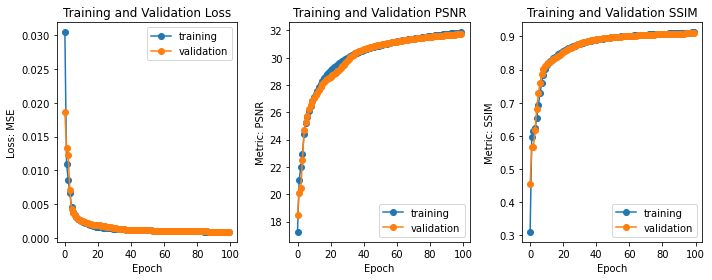

In [48]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history3.history['loss'], marker='o', label='training')
plt.plot(history3.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history3.history['PSNR'], marker='o', label='training')
plt.plot(history3.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history3.history['SSIM'], marker='o', label='training')
plt.plot(history3.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

Similar to what we saw for the 2% and 12% sample data set, after trainig the model for 100 epochs we observe that the MSE decreases while PSNR and SSIM increase as the model goes through the epochs. There is no sign of over fitting in the graphs, since we dont see a divergence between the train and validation data.

We can compare the performance of this model after training for 100 epochs with the 2% and 12% sample datasets:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0012    |   30.44    |  0.8877          |
|12% Sample dataset  |   0.0012    |    30.48     |  0.8922          |
|32% Sample dataset  |   0.0009    |    31.86     |  0.9124         |

**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0013    |   30.06    |  0.8922          |
|12% Sample dataset   |   0.0013    |    30.29     |  0.8877         |
|32% Sample dataset  |   0.0009    |    31.74     |  0.9098          |

**Contradictory to what we observed for the 2% and 12% sample datasets, we see improvments for the evaluation metrics for the 32% sample dataset with similar number of epochs**

To visualize how to the model is performing on the training images, we visualize the output of the model for a training image and compare it to the ground truth.

In [ ]:
train_predictions = autoencoder.predict(X_train)

87/87 [==============================] - 9s 102ms/step


TRAIN GROUND TRUTH:


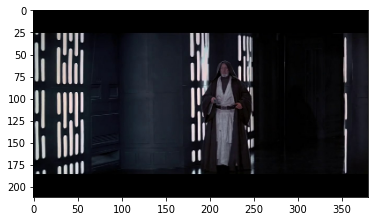

MODEL TRAIN OUTPUT:


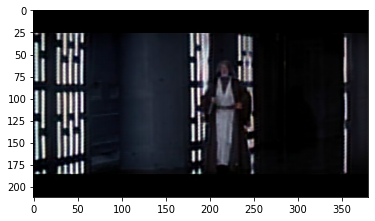

In [ ]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][29])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[29])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.057849884033203
SSIM: 0.5986228585243225
MSE: 0.014836658812976402


In [ ]:
autoencoder.evaluate(test, verbose=1)

We can now compare the performance of this model for the test images after training for 100 epochs, with the models trained with 2% and 12% sample datasets:


**Test images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |  0.0013    |   30.06   |  0.8834       |
|12% Sample dataset   |   0.0013    |    30.31     |  0.8876         |
|32% Sample dataset   |   0.0009    |    31.77     |  0.9113         |

**Similar to the trend we saw for the train and validation data, the metrics improve when the number of images is increased to 10,176 paired images.**

We will now visualize the performance of the model on the test images:

In [ ]:
test_predictions = autoencoder.predict(X_test)

48/48 [==============================] - 5s 103ms/step


TEST GROUND TRUTH:


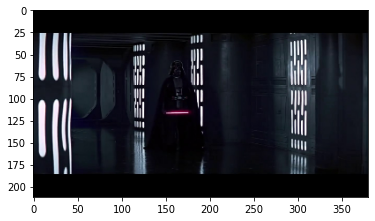

MODEL TEST OUTPUT:


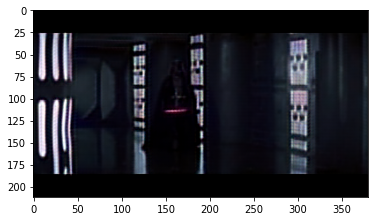

In [ ]:
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][7])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[7])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][7],test_predictions[7])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][7], test_predictions[7])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][7], test_predictions[7])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 22.622737884521484
SSIM: 0.6187282204627991
MSE: 0.016400133045519977


We will now evaluate the performance of the model trained with 2% of the dataset for 300 epochs with a dataset of low resolution old images to see how the model will reconstruct these images.

In [58]:
# directory to the old image test dataset
TEST_IMAGE_DATA = '/content/gdrive/MyDrive/test_old_images'

In [59]:
# defining the batch and image size
image_size = (212, 380)
batch_size = 32

In [60]:
# loading the test data with .image_dataset_from_directory while changing the image size and batching the data
test_image_data = tf.keras.utils.image_dataset_from_directory(
    TEST_IMAGE_DATA,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 188 files belonging to 1 classes.


In [61]:
# normalizing the images using map function
test_image = test_image_data.map(lambda test: test/255.0)

TEST INPUT 1:


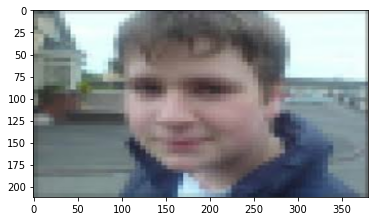

TEST INPUT 2:


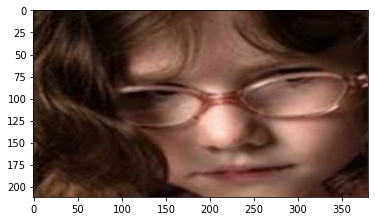

In [62]:
# visualizing 2 random pictures from the dataset
print('TEST INPUT 1:')
plt.imshow(test_image.as_numpy_iterator().next()[17])
plt.show()
print('TEST INPUT 2:')
plt.imshow(test_image.as_numpy_iterator().next()[29])
plt.show()

In [63]:
# passing the images through our data to get the model prediction
test_image_predictions = autoencoder.predict(test_image)

6/6 [==============================] - 4s 642ms/step


MODEL TEST OUTPUT 1:


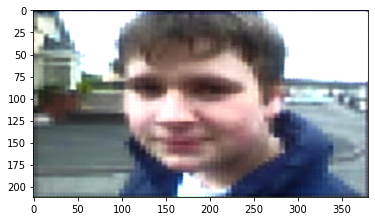

MODEL TEST OUTPUT 2:


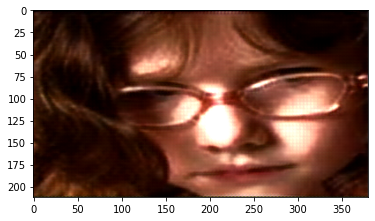

In [64]:
# Visualizing the same two pictures after the model reconstruction
print('MODEL TEST OUTPUT 1:')
plt.imshow(test_image_predictions[17])
plt.show()
print('MODEL TEST OUTPUT 2:')
plt.imshow(test_image_predictions[29])
plt.show()

Based on the evaluation metric values and validation and train graphs, we decided to run the model for 200 epochs to see if the performance of the model will improve.

In [ ]:
history3_2 = autoencoder.fit(train,
                           epochs=200,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
230/230 [==============================] - 61s 258ms/step - loss: 0.0238 - PSNR: 18.2444 - SSIM: 0.4014 - val_loss: 0.0185 - val_PSNR: 18.4132 - val_SSIM: 0.5446
Epoch 2/100
230/230 [==============================] - 59s 257ms/step - loss: 0.0102 - PSNR: 21.3427 - SSIM: 0.6447 - val_loss: 0.0125 - val_PSNR: 20.2967 - val_SSIM: 0.5898
Epoch 3/100
230/230 [==============================] - 59s 256ms/step - loss: 0.0078 - PSNR: 22.3824 - SSIM: 0.6292 - val_loss: 0.0094 - val_PSNR: 21.3643 - val_SSIM: 0.5931
Epoch 4/100
230/230 [==============================] - 63s 273ms/step - loss: 0.0054 - PSNR: 23.7093 - SSIM: 0.6416 - val_loss: 0.0047 - val_PSNR: 24.1769 - val_SSIM: 0.6523
Epoch 5/100
230/230 [==============================] - 61s 263ms/step - loss: 0.0041 - PSNR: 24.7549 - SSIM: 0.6780 - val_loss: 0.0040 - val_PSNR: 24.8760 - val_SSIM: 0.6927
Epoch 6/100
230/230 [==============================] - 59s 256ms/step - loss: 0.0037 - PSNR: 25.2355 - SSIM: 0.7009 - val_loss: 0.

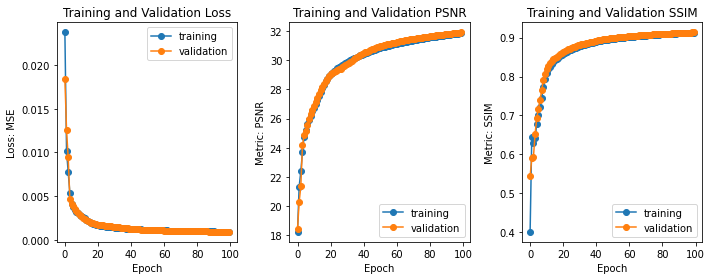

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history3_2.history['loss'], marker='o', label='training')
plt.plot(history3_2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history3_2.history['PSNR'], marker='o', label='training')
plt.plot(history3_2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history3_2.history['SSIM'], marker='o', label='training')
plt.plot(history3_2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

After training the same model with the same dataset but this time for 200 epochs, we observe the same trend for the evaluation metrics. As the model goes through the epochs, the MSE decreases and the PSNR and SSIM increase.

For the 32% sample dataset, after training the model for 100 and 200 epochs the model evaluation metrics for the training and validation images are as below:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |     0.0009    |    31.86     |  0.9124         |
|Model trained for 200 epochs   |        0.0009    |    31.86     |  0.9130       |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |     0.0009    |    31.74     |  0.9098     |
|Model trained for 200 epochs   |    0.0009    |    31.91     |  0.9134           |


**Not much imporvement is observed in the performance of the model, after training it for an additional 100 epochs.**

To visualize how to the model is performing on the training images, we visualize the output of the model for a training image and compare it to the ground truth.

In [ ]:
# we will get the predictions of the test input 
train_predictions = autoencoder.predict(X_train)

87/87 [==============================] - 9s 102ms/step


TRAIN GROUND TRUTH:


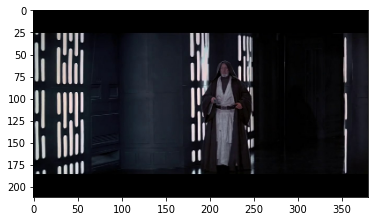

MODEL TRAIN OUTPUT:


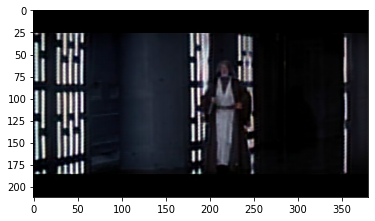

In [ ]:
# visualize the groud truth and model output for a train image
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][29])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[29])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][29], train_predictions[29])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 23.057849884033203
SSIM: 0.5986228585243225
MSE: 0.014836658812976402


In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

48/48 [==============================] - 12s 239ms/step - loss: 9.3669e-04 - PSNR: 31.7739 - SSIM: 0.9113


[0.0009366863523609936, 31.773860931396484, 0.9113097190856934]

We will now visualize the performance of the model on the test images:

In [ ]:
# get the model predictions for the input test data
test_predictions = autoencoder.predict(X_test)

48/48 [==============================] - 5s 103ms/step


TEST GROUND TRUTH:


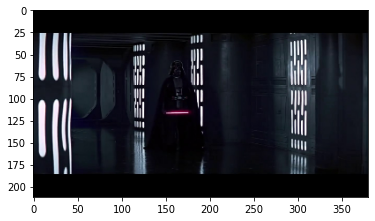

MODEL TEST OUTPUT:


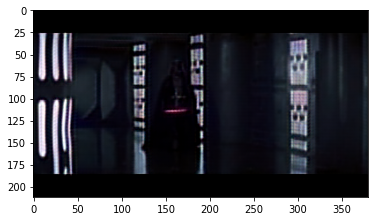

In [ ]:
# visualize the test ground truth and the model test output
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][7])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[7])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][7],test_predictions[7])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][7], test_predictions[7])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][7], test_predictions[7])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 22.622737884521484
SSIM: 0.6187282204627991
MSE: 0.016400133045519977


## Conclusions

- The dataset was too large to be effectively trained by a deep learning model with our limited time and resources. Therefore, we train our models on three samples of the original dataset with 2%, 12% and 32% of the images.
- Since our images are unlabeled, we cannot use `ImageDataGenerator` and `.flow_from_directory` to load and preprocess our images. These two methods are designed for classification problems and labeled data.
- `image_dataset_from_directory` is the generator we used to import and preprocess our images.
- The key point of our dataset is the fact that the images are in pairs and both images need to be fed into our model for training, validation and testing.
- We divided the images into train, validation and test ourselves, instead of relying on the generator to split the train and validation for us.
- We use a separate generator for each directory we have. Since we have 6 folders for input and output of train, validation and test images, we have 6 different generators for our modeling.
- The structure we chose for our unsupervised modeling is the structure of a convolutional autoencoder.
- The model has 29,507 trainable parameters.
- We use MSE as the loss function, and PSNR and SSIM as the model's evaluation metrics.
- We train our model on three datasets, containing 2%, 12% and 32% of the total images.
- We train our model with each dataset twice, once with 100 epochs and once with an additional 200 epochs (300 epochs in total)
- We use a low-resolution old image dataset to further test our model after training.
- The best performing model is the model trained on 12% of the dataset for 300 epochs.
- In the case of 2% and 12% sample datasets (636 and 3,816 paired images) the performance of the model did not differ significantly and the factor affecting the performance was the number of epochs and training duration.
- We can conclude that if we had more time and computational resources, we were able to improve the model performance significantly by using a larger sample or the total dataset and training the model for longer durations.
